In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
emitStr = '14'
emit = float(emitStr)*1.0e-9
n_particles = 2048

NL_t = 0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

Me = 511005.0 #impact.util.Me
ke = 100*1.0e6
energy = ke+Me
freq = 30*1.0e6
offset = 0.001

Espread = 9.0e-5
g = energy/Me
bg = np.sqrt(g**2-1.0)
emitN = emit*bg
print(g,emitN,Espread*energy)

turns = 100 #int(100/np.sqrt(emitN))
print(turns)

alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

196.692801440299 2.753663631443181e-06 9045.990450000001
100


# Prepare beam & lattice

In [3]:
beam, lattice = impact.readInputFile('test_shifted.in')

reading ImpactZ input file (test_shifted.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beam.current = 0.0
beam.kinetic_energy = ke
beam.mass = Me
beam.charge = -1.0
beam.frequency = freq
beam.nCore_y = 2
beam.nCore_z = 2
beam.n_particles = n_particles
beam.current = 0.0

In [5]:
# ke = beam.kinetic_energy
# Me = beam.mass
# freq = beam.frequency

In [6]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice[0].turns = turns

In [7]:
L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

39.96822971580008


In [8]:
beam.distribution.distribution_type = 'Gauss'
beam.distribution.betx  = betaEntrance
beam.distribution.alfx  = alfaEntrance
beam.distribution.emitx = emitN
beam.distribution.bety  = betaEntrance
beam.distribution.alfy  = alfaEntrance
beam.distribution.emity = emitN
beam.distribution.betz  = 200 #99999986297.78835
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (Espread*energy*1.0e-6)**2*beam.distribution.betz #9.999998482578858e-16 

In [9]:
beam.distribution


 distribution_type: 'Gauss'
              mode: 'twiss'
              betz: 200 [degree/MeV]
              alfz: 0.0
             emitz: 0.016365988644298245 [degree-MeV]
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]
              betx: 1.8926320036288808 [m]
              alfx: 1.3763819204711734
             emitx: 2.753663631443181e-06 [m-rad]
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
              bety: 1.8926320036288808 [m]
              alfy: 1.3763819204711734
             emity: 2.753663631443181e-06 [m-rad]
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]

# prepare pData ( Gaussian beam with offset)

In [10]:
testLat = [copy(lattice[0])]
testLat[0].turns=0
impact.writeInputFile(beam,testLat)
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


256

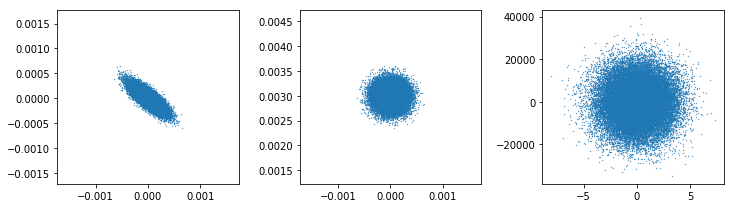

In [11]:
pData = impact.readParticleData(-111110,ke,Me,freq)
pData[:,2] = pData[:,2] + offset
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pData[:,0],pData[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pData[:,0],pData[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pData[:,4],pData[:,5],s=0.1)
plt.tight_layout()

# run

In [ ]:
impact.writeParticleData(pData,ke,Me,freq)
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,lattice)
impact.run(beam)

In [ ]:
fort82=np.loadtxt('fort.82')
X = fort82[:,3] + 1j*fort82[:,4]
# np.save('Y.mid.emit'+emitStr+'nm',X)
# print('Y.mid.shape',X.shape)

In [ ]:
tune = np.linspace(0,1,len(X))
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.plot(np.abs(X)/np.abs(X[0]))
plt.subplot(1,3,2)
plt.plot(tune,np.real(np.fft.fft(X)))
plt.subplot(1,3,3)
plt.plot(tune,np.imag(np.fft.fft(X)))
plt.tight_layout()
plt.savefig('decoherence.png',dpi=180)